In [1]:
from googleapiclient.discovery import build
import os
api_key = os.getenv('YT_API_KEY')
if api_key is None:
    print("WARNING: API Key not found as environment variable 'YT_API_KEY'.")
    
try:
    youtube = build('youtube', 'v3', developerKey=api_key)
    print("YouTube API client initialized successfully!")
except Exception as e:
    print(f"ERROR: Failed to initialize YouTube API client. Check your API key and internet connection. Error: {e}")    

YouTube API client initialized successfully!


In [11]:
import pandas as pd
import time
channel_ids = [
    'UC8RQJngOnRikpPipb9McSJw',
    'UCbbUVsLawf0-Q5-ng_EjyUQ',
    'UCP2MvAUK-II5TnPmSDUuEPg',
    'UCAIZXE2koD2-oLFLjNEyadw',
    'UCJD-UtyBgYWqvmp_lknn7Lg',
    'UCPmr5vdBEJnIybRyFKLKdyw',
    'UC92Dnjqv_PzE3t_6d2J5uYw',
    'UCBGFX2wURc0TPxsZiuV0clg', 
    'UCzKNuQ80qNSpt2x-7dsazJg'
]
channel_ids = list(set(channel_ids))
print(f"Number of unique channels to analyze: {len(channel_ids)}")
print("Channel IDs prepared for extraction.")


Number of unique channels to analyze: 9
Channel IDs prepared for extraction.


In [22]:
print("\nFetching channel-level data...")
channel_data = [] # Empty list to store the extracted data for each channel

# Loop through each unique channel ID
for channel_id in channel_ids:
    try:
        # Make the API request to get channel snippet (name, description)
        # and statistics (subscriber count, view count, video count).
        request = youtube.channels().list(
            part="snippet,statistics,brandingSettings",
            id=channel_id
        )
        response = request.execute()

        # Check if the API returned any items for this channel ID
        if response['items']:
            item = response['items'][0] # Get the first (and usually only) item
            data = {
                'channel_id': item['id'],
                'channel_name': item['snippet']['title'],
                # Use .get() with a default of 0 to safely handle cases where stats might be missing
                'subscriber_count': int(item['statistics'].get('subscriberCount', 0)),
                'view_count': int(item['statistics'].get('viewCount', 0)),
                'video_count': int(item['statistics'].get('videoCount', 0)),
                'channel_creation_date': item['snippet']['publishedAt']
            }
            channel_data.append(data) # Add the channel's data to our list
        else:
            print(f"Warning: No data found for channel ID: {channel_id}") # Inform if an ID didn't return data

    except Exception as e:
        print(f"Error fetching data for channel ID {channel_id}: {e}") # Catch and print any errors

# Convert the list of channel dictionaries into a Pandas DataFrame
df_channels = pd.DataFrame(channel_data)

print("Channel-level data fetched!")
# Display the first few rows and the shape of the DataFrame to verify
print(df_channels.head())
print(f"\nDataFrame shape: {df_channels.shape} (rows, columns)")


Fetching channel-level data...
Channel-level data fetched!
                 channel_id              channel_name  subscriber_count  \
0  UC92Dnjqv_PzE3t_6d2J5uYw  Dok'a Podcast | ዶቃ ፖድካስት              7470   
1  UCP2MvAUK-II5TnPmSDUuEPg                MindseTube            148000   
2  UCJD-UtyBgYWqvmp_lknn7Lg                 ወቸው GOOD             309000   
3  UC8RQJngOnRikpPipb9McSJw            Loline Podcast              4760   
4  UCAIZXE2koD2-oLFLjNEyadw              wesocultured               938   

   view_count  video_count        channel_creation_date  
0      243168           29  2024-12-27T14:27:11.500323Z  
1     8376396          454         2018-02-12T14:10:08Z  
2    31996776          142  2022-08-25T15:04:36.708688Z  
3      122905           33  2020-10-11T12:15:22.729467Z  
4      105312           51  2024-09-26T22:15:58.832393Z  

DataFrame shape: (9, 6) (rows, columns)


In [24]:
import pandas as pd # Make sure pandas is imported if not globally
print("Starting data cleaning and transformation for df_channels...")

# Step 8.1: Convert numeric columns to actual numeric types
df_channels['subscriber_count'] = pd.to_numeric(df_channels['subscriber_count'])
df_channels['view_count'] = pd.to_numeric(df_channels['view_count'])
df_channels['video_count'] = pd.to_numeric(df_channels['video_count'])

# Step 8.2: Convert 'channel_creation_date' to datetime objects
# Use errors='coerce' to turn unparseable dates into NaT (Not a Time)
df_channels['channel_creation_date'] = pd.to_datetime(df_channels['channel_creation_date'], errors='coerce')

# Step 8.3: Extract just the date part (optional, but often cleaner for analysis)
# Ensure to handle potential NaT values after coercion
df_channels['channel_creation_date_only'] = df_channels['channel_creation_date'].dt.date

# Remove rows where channel_creation_date is NaT (if conversion failed for some)
# This line ensures that only valid date entries remain for analysis
df_channels.dropna(subset=['channel_creation_date'], inplace=True)

print("\ndf_channels after cleaning:")
print(df_channels.info()) # This shows the data types and non-null counts
print("\nFirst 5 rows of cleaned df_channels:")
print(df_channels.head())

Starting data cleaning and transformation for df_channels...

df_channels after cleaning:
<class 'pandas.core.frame.DataFrame'>
Index: 7 entries, 0 to 8
Data columns (total 7 columns):
 #   Column                      Non-Null Count  Dtype              
---  ------                      --------------  -----              
 0   channel_id                  7 non-null      object             
 1   channel_name                7 non-null      object             
 2   subscriber_count            7 non-null      int64              
 3   view_count                  7 non-null      int64              
 4   video_count                 7 non-null      int64              
 5   channel_creation_date       7 non-null      datetime64[ns, UTC]
 6   channel_creation_date_only  7 non-null      object             
dtypes: datetime64[ns, UTC](1), int64(3), object(3)
memory usage: 448.0+ bytes
None

First 5 rows of cleaned df_channels:
                 channel_id              channel_name  subscriber_count 

In [14]:
#data cleaning and tr

""


In [25]:
import time # Import the time module to add delays

print("\nFetching video-level data (this might take a while for many channels/videos)...")
video_data = [] # Empty list to store data for each individual video

# Define a maximum number of videos to fetch per channel to manage API quota
MAX_VIDEOS_PER_CHANNEL = 100 # Limiting quota to fetch videos through the YT API

# Loop through each channel ID to get their videos
for channel_id in channel_ids:
    print(f"  Processing videos for channel: {channel_id}")
    next_page_token = None # API pagination Used for pagination to get more than 50 results
    video_count_for_channel = 0 # Counter for videos fetched for the current channel

    # Loop to get all pages of videos until no more pages or max limit is reached
    while True:
        # Make a search request to get video IDs from the channel
        # This API call returns IDs and basic snippet info for videos in a channel.
        search_request = youtube.search().list(  # get a list of video IDs for a given channel
            part="id,snippet", # specifying what info to extract
            channelId=channel_id, # to only return videos uploaded by only the current channel
            maxResults=50, # Maximum allowed per search request (50 items)
            type="video", # Ensure we only get videos, not playlists or channels
            pageToken=next_page_token # Use the token to get the next page of results
        )
        search_response = search_request.execute() # request data

        # Extract video IDs from the search response for detailed stats request
        video_ids_for_batch = [item['id']['videoId'] for item in search_response['items'] if 'videoId' in item['id']]

        if video_ids_for_batch: # check if we get any video in the search.lis
            # Now, make a separate API call to get detailed statistics for these specific video IDs
            # The videos.list API is more efficient for getting stats for multiple videos at once.
            videos_request = youtube.videos().list(
                part="snippet,statistics,contentDetails", # Request video snippet, statistics, and contentDetails
                id=",".join(video_ids_for_batch) # Join the list of IDs into a comma-separated string / videos.list API expects a comma separated string of video IDs
            )
            videos_response = videos_request.execute()

            # Process each video item from the detailed response
            for item in videos_response['items']:
                stats = item['statistics'] # extracts the 'statistics' dictionary from the current video
                video_info = { # giving clean, readable keys for the Python Dictionary/infor of the video
                    'channel_id': channel_id,
                    'video_id': item['id'],
                    'video_title': item['snippet']['title'],
                    'published_at': item['snippet']['publishedAt'],
                    # Safely get counts, converting to int. Use 0 if missing (e.g., likes disabled)
                    'view_count': int(stats.get('viewCount', 0)),
                    'like_count': int(stats.get('likeCount', 0)),
                    'comment_count': int(stats.get('commentCount', 0)),
                    'duration': item['contentDetails']['duration'], # This is in ISO 8601 format (e.g., PT5M30S)
                    'description': item['snippet']['description'],
                    'tags': item['snippet'].get('tags', []) # Videos may not have tags, default to empty list
                }
                video_data.append(video_info) # Add video data to our list
                video_count_for_channel += 1 # Increment the counter for this channel

        # Check if there are more pages of results or if we've hit our maximum video limit for this channel
        next_page_token = search_response.get('nextPageToken')
        if not next_page_token or video_count_for_channel >= MAX_VIDEOS_PER_CHANNEL:
            break # Exit the loop if no more pages or if the limit is reached

        # Add a small delay between API calls to respect YouTube's quota limits
        time.sleep(0.1) # 0.1 seconds delay

# Convert the list of video dictionaries into a Pandas DataFrame
df_videos = pd.DataFrame(video_data)

print("\nVideo-level data fetched!")
# Display the first few rows and the shape of the DataFrame to verify
print(df_videos.head())
print(f"\nDataFrame shape: {df_videos.shape} (rows, columns)")


Fetching video-level data (this might take a while for many channels/videos)...
  Processing videos for channel: UC92Dnjqv_PzE3t_6d2J5uYw
  Processing videos for channel: UCP2MvAUK-II5TnPmSDUuEPg
  Processing videos for channel: UCJD-UtyBgYWqvmp_lknn7Lg
  Processing videos for channel: UC8RQJngOnRikpPipb9McSJw
  Processing videos for channel: UCAIZXE2koD2-oLFLjNEyadw
  Processing videos for channel: UCPmr5vdBEJnIybRyFKLKdyw
  Processing videos for channel: UCbbUVsLawf0-Q5-ng_EjyUQ
  Processing videos for channel: UCzKNuQ80qNSpt2x-7dsazJg
  Processing videos for channel: UCBGFX2wURc0TPxsZiuV0clg

Video-level data fetched!
                 channel_id     video_id  \
0  UC92Dnjqv_PzE3t_6d2J5uYw  CdeYtTW6Lt4   
1  UC92Dnjqv_PzE3t_6d2J5uYw  LR3QEZYltW8   
2  UC92Dnjqv_PzE3t_6d2J5uYw  UUM_YFe2PCM   
3  UC92Dnjqv_PzE3t_6d2J5uYw  WJG5VsgtfEM   
4  UC92Dnjqv_PzE3t_6d2J5uYw  glkl5_EHfqY   

                                         video_title          published_at  \
0  ቀረፃ መሀል ሀንግ? #doka #habe

In [19]:
import re # Import regular expression module for duration parsing

print("\nStarting data cleaning and transformation for df_videos...")

# Convert numeric columns to actual numeric types for df_videos
# These also come as strings from the API
df_videos['view_count'] = pd.to_numeric(df_videos['view_count'])
df_videos['like_count'] = pd.to_numeric(df_videos['like_count'])
df_videos['comment_count'] = pd.to_numeric(df_videos['comment_count'])

#  Convert 'published_at' to datetime objects
df_videos['published_at'] = pd.to_datetime(df_videos['published_at'])

# Extract just the date part for 'published_at'
df_videos['published_date_only'] = df_videos['published_at'].dt.date

#  Convert ISO 8601 duration string to total seconds
# This is a custom function to parse the 'PT...H...M...S' format
def parse_duration(duration_str):
    if not isinstance(duration_str, str): # Handle non-string inputs gracefully
        return 0
    
    # Regex to find hours, minutes, seconds
    hours = re.search(r'(\d+)H', duration_str)
    minutes = re.search(r'(\d+)M', duration_str)
    seconds = re.search(r'(\d+)S', duration_str)

    total_seconds = 0
    if hours:
        total_seconds += int(hours.group(1)) * 3600
    if minutes:
        total_seconds += int(minutes.group(1)) * 60
    if seconds:
        total_seconds += int(seconds.group(1))

    return total_seconds

# Apply the function to the 'duration' column to create a new 'duration_seconds' column
df_videos['duration_seconds'] = df_videos['duration'].apply(parse_duration)

#  Extract year and month from published_at for potential time series analysis
df_videos['published_year'] = df_videos['published_at'].dt.year
df_videos['published_month'] = df_videos['published_at'].dt.month

#  Handle missing values (e.g., if a video has no description or tags)
# For 'description', fill missing (NaN) with an empty string
df_videos['description'] = df_videos['description'].fillna('')
# For 'tags', fill missing (NaN) with an empty list
df_videos['tags'] = df_videos['tags'].apply(lambda x: [] if not isinstance(x, list) else x)


print("\ndf_videos after cleaning:")
print(df_videos.info()) # Check data types and non-null counts again
print("\nFirst 5 rows of cleaned df_videos (including new duration_seconds column):")
print(df_videos.head())


Starting data cleaning and transformation for df_videos...

df_videos after cleaning:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 572 entries, 0 to 571
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype              
---  ------               --------------  -----              
 0   channel_id           572 non-null    object             
 1   video_id             572 non-null    object             
 2   video_title          572 non-null    object             
 3   published_at         572 non-null    datetime64[ns, UTC]
 4   view_count           572 non-null    int64              
 5   like_count           572 non-null    int64              
 6   comment_count        572 non-null    int64              
 7   duration             572 non-null    object             
 8   description          572 non-null    object             
 9   tags                 572 non-null    object             
 10  published_date_only  572 non-null    object             
 1

In [28]:
import pandas as pd
print("Starting data cleaning and transformation for df_channels...")

# Step 8.1: Convert numeric columns to actual numeric types
df_channels['subscriber_count'] = pd.to_numeric(df_channels['subscriber_count'])
df_channels['view_count'] = pd.to_numeric(df_channels['view_count'])
df_channels['video_count'] = pd.to_numeric(df_channels['video_count'])

# Step 8.2: Convert 'channel_creation_date' to datetime objects
# Use errors='coerce' to turn unparseable dates into NaT (Not a Time)
df_channels['channel_creation_date'] = pd.to_datetime(df_channels['channel_creation_date'], errors='coerce')

# Step 8.3: Extract just the date part (optional, but often cleaner for analysis)
# Ensure to handle potential NaT values after coercion
df_channels['channel_creation_date_only'] = df_channels['channel_creation_date'].dt.date

# Remove rows where channel_creation_date is NaT (if conversion failed for some)
# This line ensures that only valid date entries remain for analysis
df_channels.dropna(subset=['channel_creation_date'], inplace=True)

print("\ndf_channels after cleaning:")
print(df_channels.info()) # This shows the data types and non-null counts
print("\nFirst 5 rows of cleaned df_channels:")
print(df_channels.head())

Starting data cleaning and transformation for df_channels...

df_channels after cleaning:
<class 'pandas.core.frame.DataFrame'>
Index: 7 entries, 0 to 8
Data columns (total 8 columns):
 #   Column                      Non-Null Count  Dtype              
---  ------                      --------------  -----              
 0   channel_id                  7 non-null      object             
 1   channel_name                7 non-null      object             
 2   subscriber_count            7 non-null      int64              
 3   view_count                  7 non-null      int64              
 4   video_count                 7 non-null      int64              
 5   channel_creation_date       7 non-null      datetime64[ns, UTC]
 6   channel_creation_date_only  7 non-null      object             
 7   creation_year               7 non-null      int32              
dtypes: datetime64[ns, UTC](1), int32(1), int64(3), object(3)
memory usage: 476.0+ bytes
None

First 5 rows of cleaned df_cha

In [19]:
df_videos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype              
---  ------               --------------  -----              
 0   channel_id           569 non-null    object             
 1   video_id             569 non-null    object             
 2   video_title          569 non-null    object             
 3   published_at         569 non-null    datetime64[ns, UTC]
 4   view_count           569 non-null    int64              
 5   like_count           569 non-null    int64              
 6   comment_count        569 non-null    int64              
 7   duration             569 non-null    object             
 8   description          569 non-null    object             
 9   tags                 569 non-null    object             
 10  published_date_only  569 non-null    object             
 11  duration_seconds     569 non-null    int64              
 12  published_year       5

In [26]:
df_videos.head()

,channel_id,video_id,video_title,published_at,view_count,like_count,comment_count,duration,description,tags
0,UC92Dnjqv_PzE3t_6d2J5uYw,CdeYtTW6Lt4,ቀረፃ መሀል ሀንግ? #doka #habesha #wechewgud #dokapo...,2025-02-01T13:18:22Z,628,21,1,PT28S,,[]
1,UC92Dnjqv_PzE3t_6d2J5uYw,LR3QEZYltW8,'' i believe i am a channel for healing others...,2025-02-26T17:39:33Z,657,19,1,PT28S,,[]
2,UC92Dnjqv_PzE3t_6d2J5uYw,UUM_YFe2PCM,የምፈልገውን ነገር ከሰጠህኝ የምደሰት ሴት ነኝ።|ጆርዲን በዛብህ|2025|,2025-05-20T15:25:48Z,760,20,0,PT13S,ፌሚኒዝም፣እድሜ፣ፍቅር . . .,[]
3,UC92Dnjqv_PzE3t_6d2J5uYw,WJG5VsgtfEM,ልጁን አደንዝዞ የ100ሺ ዶላር እድል ያስመልጣል #doka #habesha ...,2025-02-14T21:04:09Z,194,1,0,PT1M10S,,[]
4,UC92Dnjqv_PzE3t_6d2J5uYw,glkl5_EHfqY,ፌሚኒዝም ከባህል ፣ ከሃይማኖት ፣ ከማህበራዊ መሰረት አንፃር የፊታችን አ...,2025-06-05T09:13:06Z,10409,162,92,PT4M22S,የሥነ ፆታ እኩልነትን አስመልክቶ ጆርዲን በዛብህ ከዶቃ ፖድካስት ጋር ባደ...,"[jordin bezabih storytime, jordin bezabih yout..."


Performing initial analysis on df_channels...

--- Top 10 Channels by Subscriber Count ---
               channel_name  subscriber_count
2                 ወቸው GOOD             309000
8             ALIVE PODCAST            102000
5                  ሳቅ ሴንትራል             48300
0  Dok'a Podcast | ዶቃ ፖድካስት              7470
6     ፍጥረት | Fitret Podcast              6970
3            Loline Podcast              4760
4              wesocultured               938


C:\Users\HP\AppData\Local\Temp\ipykernel_2652\717874511.py:24: UserWarning: Glyph 4808 (\N{ETHIOPIC SYLLABLE WA}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\HP\AppData\Local\Temp\ipykernel_2652\717874511.py:24: UserWarning: Glyph 4728 (\N{ETHIOPIC SYLLABLE CA}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\HP\AppData\Local\Temp\ipykernel_2652\717874511.py:24: UserWarning: Glyph 4813 (\N{ETHIOPIC SYLLABLE WE}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\HP\AppData\Local\Temp\ipykernel_2652\717874511.py:24: UserWarning: Glyph 4659 (\N{ETHIOPIC SYLLABLE SAA}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\HP\AppData\Local\Temp\ipykernel_2652\717874511.py:24: UserWarning: Glyph 4677 (\N{ETHIOPIC SYLLABLE QE}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\HP\AppData\Local\Temp\ipykernel_2652\717874511.py:24: UserWarning: Glyph 4660 (\N{ETHIOPIC SYLLABLE SEE}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\HP\AppData\

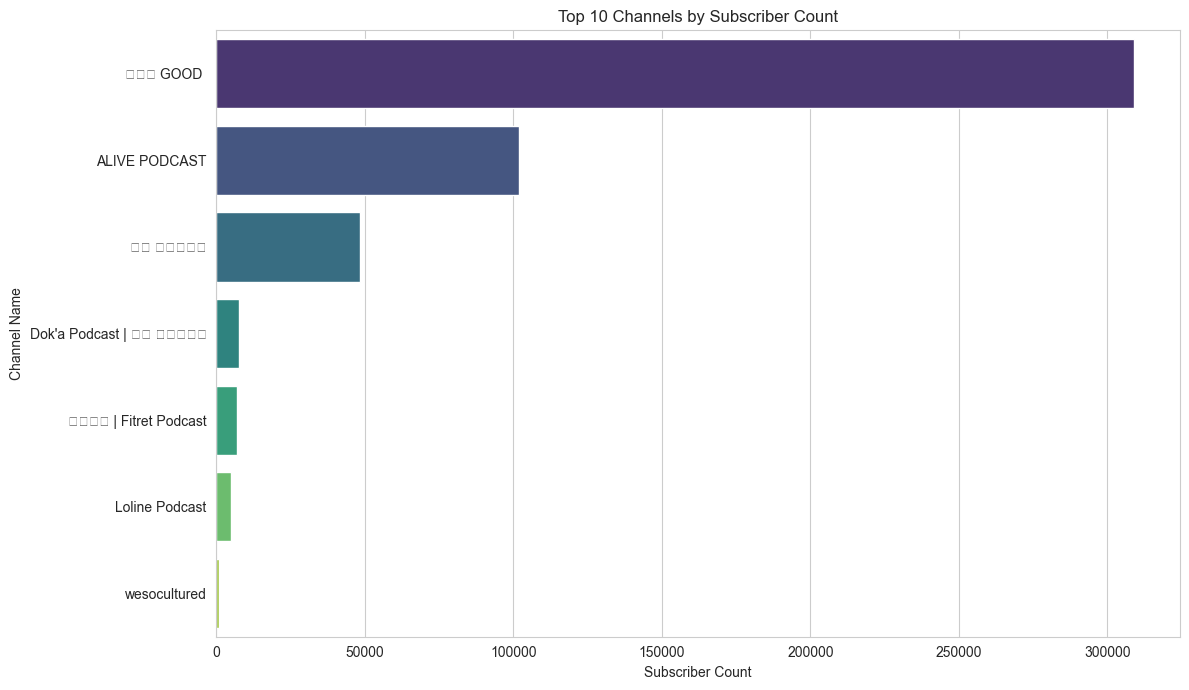


--- Top 10 Channels by Total View Count ---
               channel_name  view_count
2                 ወቸው GOOD     31996776
5                  ሳቅ ሴንትራል     3838061
8             ALIVE PODCAST     2532598
6     ፍጥረት | Fitret Podcast      590341
0  Dok'a Podcast | ዶቃ ፖድካስት      243168
3            Loline Podcast      122905
4              wesocultured      105312


C:\Users\HP\AppData\Local\Temp\ipykernel_2652\717874511.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='view_count', y='channel_name', data=top_10_views, palette='plasma')
C:\Users\HP\AppData\Local\Temp\ipykernel_2652\717874511.py:38: UserWarning: Glyph 4808 (\N{ETHIOPIC SYLLABLE WA}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\HP\AppData\Local\Temp\ipykernel_2652\717874511.py:38: UserWarning: Glyph 4728 (\N{ETHIOPIC SYLLABLE CA}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\HP\AppData\Local\Temp\ipykernel_2652\717874511.py:38: UserWarning: Glyph 4813 (\N{ETHIOPIC SYLLABLE WE}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\HP\AppData\Local\Temp\ipykernel_2652\717874511.py:38: UserWarning: Glyph 4659 (\N{ETHIOPIC SYLLABLE SAA}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\HP\AppD

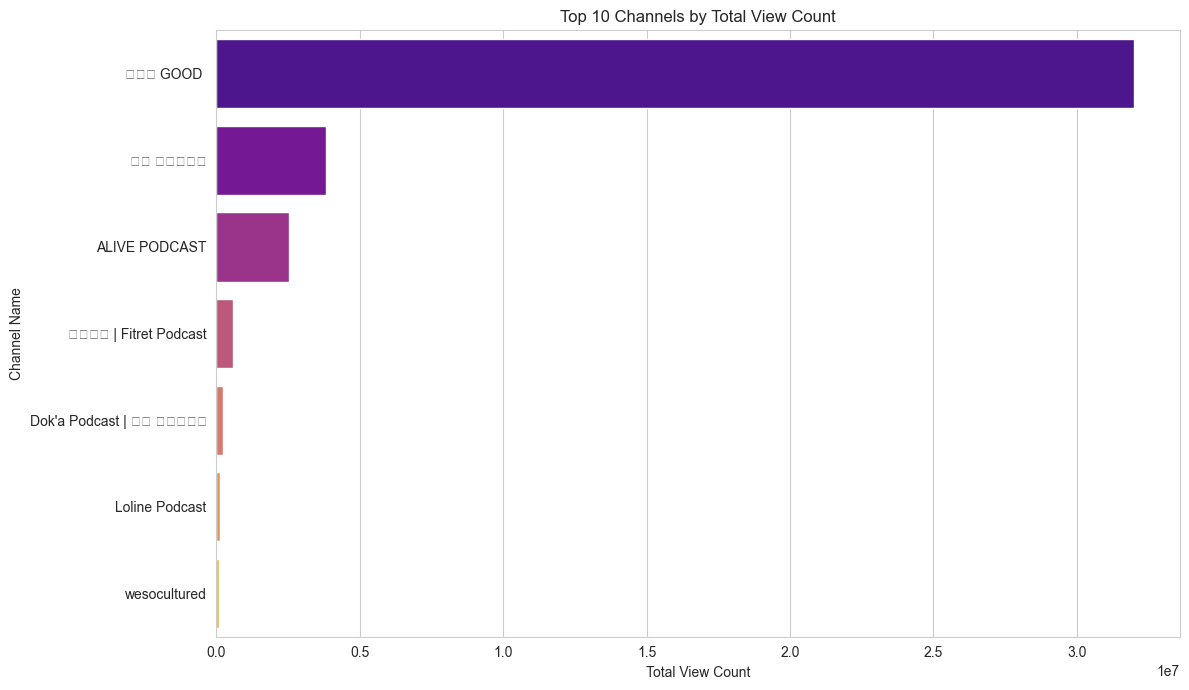


--- Channel Creation Date Distribution (Years) ---
creation_year
2020    1
2022    1
2023    2
2024    3
Name: count, dtype: int64


C:\Users\HP\AppData\Local\Temp\ipykernel_2652\717874511.py:49: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(x=creation_year_counts.index, y=creation_year_counts.values, marker='o', palette='cividis')


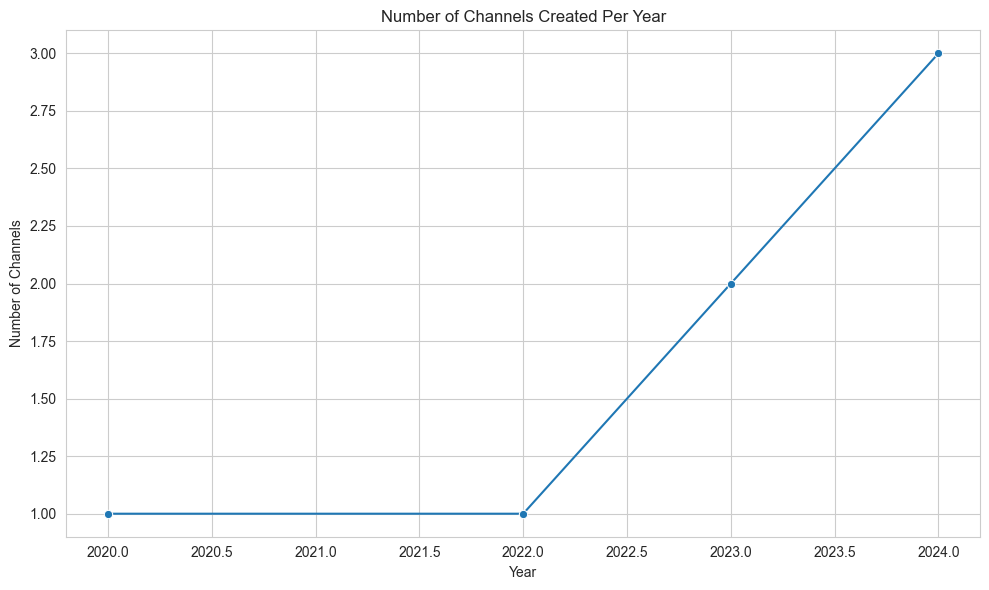


Channel-level analysis complete!


In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl

print("Performing initial analysis on df_channels...")
mpl.rcParams['font.family'] = ['Nyala', 'DejaVu Sans', 'sans-serif']
mpl.rcParams['axes.unicode_minus'] = False 

# Set a style for plots
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6) # Set default figure size

# 9.1 Top 10 Channels by Subscriber Count
print("\n--- Top 10 Channels by Subscriber Count ---")
top_10_subscribers = df_channels.sort_values(by='subscriber_count', ascending=False).head(10)
print(top_10_subscribers[['channel_name', 'subscriber_count']])

# Plot Top 10 Channels by Subscriber Count
plt.figure(figsize=(12, 7))
sns.barplot(x='subscriber_count', y='channel_name', data=top_10_subscribers, palette='viridis', hue='channel_name', legend=False)
plt.title('Top 10 Channels by Subscriber Count')
plt.xlabel('Subscriber Count')
plt.ylabel('Channel Name')
plt.tight_layout()
plt.show()

# 9.2 Top 10 Channels by Total View Count
print("\n--- Top 10 Channels by Total View Count ---")
top_10_views = df_channels.sort_values(by='view_count', ascending=False).head(10)
print(top_10_views[['channel_name', 'view_count']])

# Plot Top 10 Channels by Total View Count
plt.figure(figsize=(12, 7))
sns.barplot(x='view_count', y='channel_name', data=top_10_views, palette='plasma')
plt.title('Top 10 Channels by Total View Count')
plt.xlabel('Total View Count')
plt.ylabel('Channel Name')
plt.tight_layout()
plt.show()

# 9.3 Distribution of Channel Creation Dates (by Year)
print("\n--- Channel Creation Date Distribution (Years) ---")
df_channels['creation_year'] = df_channels['channel_creation_date'].dt.year
creation_year_counts = df_channels['creation_year'].value_counts().sort_index()
print(creation_year_counts)

# Plot Distribution of Channel Creation Dates
plt.figure(figsize=(10, 6))
sns.lineplot(x=creation_year_counts.index, y=creation_year_counts.values, marker='o', palette='cividis')
plt.title('Number of Channels Created Per Year')
plt.xlabel('Year')
plt.ylabel('Number of Channels')
plt.grid(True)
plt.tight_layout()
plt.show()

print("\nChannel-level analysis complete!")

In [1]:
top_10_subscribers = df_channels.sort_values(by='subscriber_count', ascending=False).head(10)

NameError: name 'df_channels' is not defined